In [ ]:
!pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
import os

In [3]:
CLEANED_DATA_FILE = 'data/cleaned_bangalore_data.csv'
MODEL_FILE = 'xgboost_model.joblib'
TARGET_COLUMN = 'Phase3_power'

In [4]:
def create_features(df):
    """
    Create time series features from a datetime index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [5]:
print(f"Loading cleaned data from {CLEANED_DATA_FILE}...")
try:
    # Load the data, setting the index to our datetime column
    df = pd.read_csv(CLEANED_DATA_FILE, index_col='_time', parse_dates=True)
except FileNotFoundError:
    print(f"ERROR: Cleaned data file not found at {CLEANED_DATA_FILE}")
    print("Please make sure you have successfully run 'data_processing_pipeline.py' first.")
    exit()
except KeyError:
    print(f"ERROR: Could not find the '_time' column. Was the file saved correctly?")
    exit()
except Exception as e:
    print(f"An error occurred loading the data: {e}")
    exit()

print("Applying feature engineering (create_features)...")
df = create_features(df)

Loading cleaned data from data/cleaned_bangalore_data.csv...
Applying feature engineering (create_features)...


In [6]:
TARGET = TARGET_COLUMN

if TARGET not in df.columns:
    print(f"!!! ERROR: Target column '{TARGET}' not found in the data. !!!")
    print("Please check the 'TARGET_COLUMN' variable at the top of this script.")
    print(f"Available columns are: {df.columns.tolist()}")
    exit()

FEATURES = [
    # Sensor features from your CSV:
    'Phase2_current', 
    'Phase2_voltage', 
    'Phase3_frequency', 
    'Phase3_pf', 
    'Phase3_voltage',
    # Time-based features we just created:
    'hour', 
    'dayofweek', 
    'month', 
    'quarter', 
    'year', 
    'dayofyear'
]
# Note: We automatically exclude the TARGET_COLUMN ('Phase3_power') from the features.

print(f"Target variable set to: {TARGET}")
print(f"Model will be trained with these features: {FEATURES}")

Target variable set to: Phase3_power
Model will be trained with these features: ['Phase2_current', 'Phase2_voltage', 'Phase3_frequency', 'Phase3_pf', 'Phase3_voltage', 'hour', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']


In [8]:
split_date = '2021-07-15' # Using last ~1 month for testing (was 2021-11-01)
print(f"Splitting data into train/test sets at {split_date}...")

train_df = df.loc[df.index < split_date]
test_df = df.loc[df.index >= split_date]

# Check if train or test set is empty
if train_df.empty or test_df.empty:
    print(f"ERROR: Train or test set is empty. The split_date '{split_date}' may be outside your data's range.")
    print(f"Your data ranges from {df.index.min()} to {df.index.max()}.")
    exit()

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Splitting data into train/test sets at 2021-07-15...
Train set shape: (2385, 11), Test set shape: (803, 11)


In [9]:
print("Training XGBoost Regressor model...")
model = xgb.XGBRegressor(
    n_estimators=1000,          # Number of trees
    learning_rate=0.01,         # Step size shrinkage
    early_stopping_rounds=50,   # Stop if no improvement after 50 rounds
    eval_metric='rmse'          # Evaluation metric
)

# Fit the model
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], # Data to evaluate on
    verbose=100  # Print training status every 100 rounds
)

print("Model training complete.")

Training XGBoost Regressor model...
[0]	validation_0-rmse:73.34455	validation_1-rmse:25.71686
[100]	validation_0-rmse:48.45526	validation_1-rmse:17.37186
[112]	validation_0-rmse:46.86834	validation_1-rmse:17.03593
Model training complete.


In [10]:
print(f"Saving trained model to {MODEL_FILE}...")
joblib.dump(model, MODEL_FILE)

print("--- XGBoost Pipeline Complete ---")
print(f"Model saved successfully: {MODEL_FILE}")

Saving trained model to xgboost_model.joblib...
--- XGBoost Pipeline Complete ---
Model saved successfully: xgboost_model.joblib


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

In [17]:
print("\n--- Model Evaluation ---")
# Get predictions on the test data
predictions = model.predict(X_train)

# Calculate metrics
# NEW
mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse) # Or: rmse = mse**0.5
mae = mean_absolute_error(y_train, predictions)
mape = mean_absolute_percentage_error(y_train, predictions)

print(f"Test Set RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"Test Set MAE (Mean Absolute Error):   {mae:.4f}")
print(f"Test Set MAPE (Mean Abs % Error):   {mape * 100:.4f} %")

print("\n--- How to Read These Metrics ---")
print(f"RMSE/MAE: On average, the model's prediction is off by ~{mae:.2f} units of power ('{TARGET}').")
print(f"MAPE: On average, the model's prediction is off by {mape*100:.2f}%. Your project KPI is < 2%.")


--- Model Evaluation ---
Test Set RMSE (Root Mean Squared Error): 54.4732
Test Set MAE (Mean Absolute Error):   36.6024
Test Set MAPE (Mean Abs % Error):   14.8676 %

--- How to Read These Metrics ---
RMSE/MAE: On average, the model's prediction is off by ~36.60 units of power ('Phase3_power').
MAPE: On average, the model's prediction is off by 14.87%. Your project KPI is < 2%.



Generating prediction plot... saving to xgboost_prediction_vs_actual.png
--- XGBoost Pipeline Complete ---


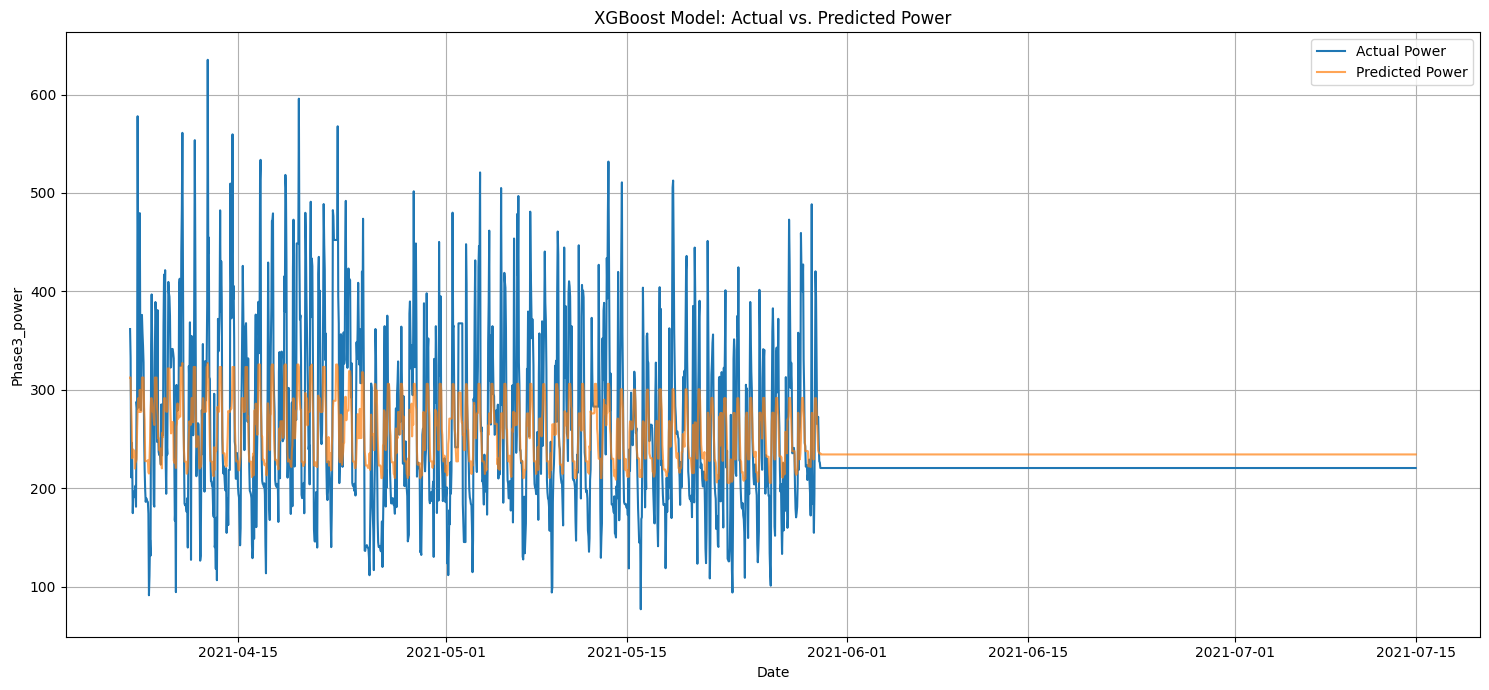

In [19]:
CHART_FILE = 'xgboost_prediction_vs_actual.png'
print(f"\nGenerating prediction plot... saving to {CHART_FILE}")

# Create the plot
plt.figure(figsize=(15, 7))
plt.plot(train_df.index, y_train, label='Actual Power')
plt.plot(train_df.index, predictions, label='Predicted Power', alpha=0.7)
plt.title('XGBoost Model: Actual vs. Predicted Power')
plt.xlabel('Date')
plt.ylabel(f'{TARGET}')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(CHART_FILE)

print("--- XGBoost Pipeline Complete ---")